In [1]:
import numpy as np
import pandas as pd
import json
import pickle
import sys
from typing import List
from collections import namedtuple
from tqdm import tqdm
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

In [2]:
paths = ['../mmd', '../shared', '../contra-lexrank']

for p in paths:
    if p not in sys.path:
        sys.path.append(p)
        
from Argument import Argument
from DataHandler import DataHandler
from ArgumentativenessScorer import ArgumentativenessScorer
from ContrastivenessScorer import ContrastivenessScorer
from ContraLexRank import ContraLexRank
from WordEmbeddingTransformer import WordEmbeddingTransformer
from CentralityScorer import CentralityScorer
from FeaturedArgument import FeaturedArgument
from myutils import cosine_similarity

C:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)


# Ansatz A

In [3]:
data = DataHandler()
data.load_bin(r"C:\Users\Jonas\git\thesis\not-gitted\argsme-crawled\1632239915.4824035-4390-arguments-cleaned-test.pickle")

In [4]:
data.validate()

False

In [5]:
keys = data.get_query_context_keys(data.get_arguments())
len(keys)

530

In [6]:
random_context_keys = np.random.choice(list(keys), size=10, replace=False)

In [7]:
subset_arguments = list()
for k in random_context_keys:
    subset_arguments.extend(DataHandler.get_query_context(data.get_arguments(), k))

In [8]:
len(subset_arguments)

82

In [9]:
wet = WordEmbeddingTransformer()

In [10]:
embedded_arguments = wet.transform(subset_arguments)

100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [01:39<00:00,  1.22s/it]


In [12]:
data = DataHandler(embedded_arguments)
data.validate()

True

In [ ]:
pipeline = Pipeline(steps=[
    ('argumentativeness', ArgumentativenessScorer(discourse_markers='../contra-lexrank/discourse-markers.txt', claim_lexicon='../contra-lexrank/ClaimLexicon.txt')),
    ('contrastiveness', ContrastivenessScorer()),
    ('centrality', CentralityScorer()),
    ('clr', ContraLexRank(d_1=.8, d_2=.9, d_3=.7, limit=2)),
])
pipeline.predict(subset_arguments)

In [14]:
args = sorted(data.get_arguments(), key=lambda a: len(a.sentences))

In [15]:
len(args[0].sentences), len(args[-1].sentences)

(3, 57)

In [43]:
shorts = args[:40]
longs = args[40:]
print(len(shorts), len(longs))

40 42


In [44]:
short_a_long_s = sorted(shorts, key=lambda a: len(word_tokenize(" ".join(np.take(a.sentences, a.excerpt_indices)))))[20:]
short_a_short_s = sorted(shorts, key=lambda a: len(word_tokenize(" ".join(np.take(a.sentences, a.excerpt_indices)))))[:20]
long_a_short_s = sorted(longs, key=lambda a: len(word_tokenize(" ".join(np.take(a.sentences, a.excerpt_indices)))))[:20]
long_a_long_s = sorted(longs, key=lambda a: len(word_tokenize(" ".join(np.take(a.sentences, a.excerpt_indices)))))[20:]

In [28]:
def snippet_scores(arguments, getter= lambda b: b.centrality_scores[0]):
    _snippet_cs = list()
    for i, a in enumerate(arguments):
        temp = getter(a).take(a.excerpt_indices)
        _snippet_cs.extend(temp)
        
    return _snippet_cs

(40,)


(array([ 1.,  0.,  0.,  0.,  6., 10.,  5.,  6.,  2., 10.]),
 array([-0.75070807, -0.57563726, -0.40056645, -0.22549565, -0.05042484,
         0.12464597,  0.29971677,  0.47478758,  0.64985839,  0.82492919,
         1.        ]),
 <BarContainer object of 10 artists>)

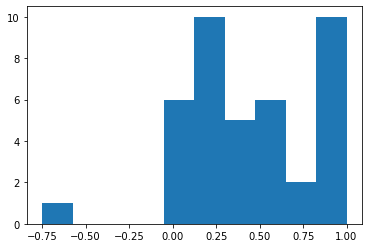

In [46]:
a = snippet_scores(short_a_long_s)
print(np.array(a).shape)
plt.hist(a)

(array([ 3.,  2.,  5.,  8.,  2.,  4.,  1.,  1., 13.,  1.]),
 array([-1.29672244e-01, -5.13261910e-04,  1.28645720e-01,  2.57804701e-01,
         3.86963683e-01,  5.16122665e-01,  6.45281646e-01,  7.74440628e-01,
         9.03599610e-01,  1.03275859e+00,  1.16191757e+00]),
 <BarContainer object of 10 artists>)

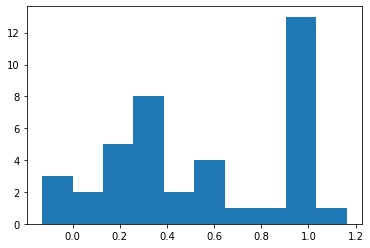

In [47]:
plt.hist(snippet_scores(short_a_short_s))

(array([ 4., 20.,  6.,  2.,  0.,  0.,  0.,  0.,  0.,  8.]),
 array([-0.14137428, -0.02723685,  0.08690058,  0.20103801,  0.31517543,
         0.42931286,  0.54345029,  0.65758772,  0.77172514,  0.88586257,
         1.        ]),
 <BarContainer object of 10 artists>)

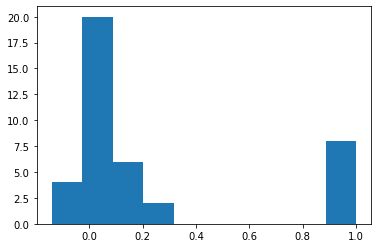

In [48]:
plt.hist(snippet_scores(long_a_short_s))

(array([20., 18.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  3.]),
 array([-0.00246453,  0.09778193,  0.19802838,  0.29827483,  0.39852128,
         0.49876774,  0.59901419,  0.69926064,  0.79950709,  0.89975355,
         1.        ]),
 <BarContainer object of 10 artists>)

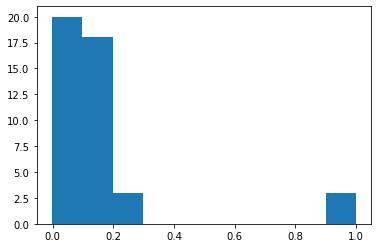

In [49]:
plt.hist(snippet_scores(long_a_long_s))

(40,)


(array([ 1.,  0.,  0.,  0.,  7.,  5.,  8., 10.,  5.,  4.]),
 array([0.12277844, 0.17768589, 0.23259333, 0.28750078, 0.34240823,
        0.39731568, 0.45222313, 0.50713057, 0.56203802, 0.61694547,
        0.67185292]),
 <BarContainer object of 10 artists>)

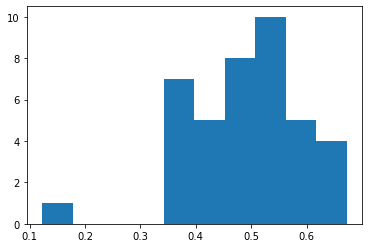

In [50]:
a = snippet_scores(short_a_long_s, getter=lambda b: b.context_similarity)
print(np.array(a).shape)
plt.hist(a)

(array([2., 1., 2., 6., 2., 6., 5., 8., 5., 3.]),
 array([0.18184202, 0.22530335, 0.26876468, 0.31222601, 0.35568734,
        0.39914868, 0.44261001, 0.48607134, 0.52953267, 0.572994  ,
        0.61645533]),
 <BarContainer object of 10 artists>)

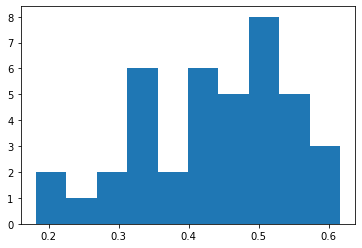

In [51]:
plt.hist(snippet_scores(short_a_short_s, getter=lambda b: b.context_similarity))

(array([ 2.,  2., 13.,  8.,  3.,  3.,  3.,  1.,  3.,  2.]),
 array([-0.05491662, -0.00375405,  0.04740852,  0.0985711 ,  0.14973367,
         0.20089624,  0.25205881,  0.30322138,  0.35438395,  0.40554653,
         0.4567091 ]),
 <BarContainer object of 10 artists>)

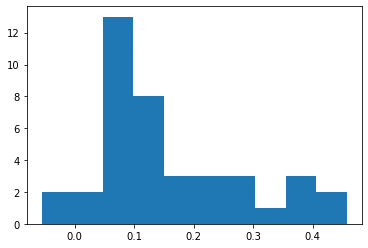

In [52]:
plt.hist(snippet_scores(long_a_short_s, getter=lambda b: b.context_similarity))

(array([1., 4., 8., 8., 8., 3., 4., 5., 2., 1.]),
 array([0.04583942, 0.10406824, 0.16229705, 0.22052586, 0.27875468,
        0.33698349, 0.39521231, 0.45344112, 0.51166993, 0.56989875,
        0.62812756]),
 <BarContainer object of 10 artists>)

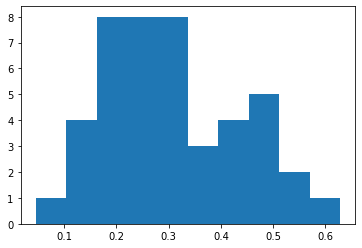

In [53]:
plt.hist(snippet_scores(long_a_long_s, getter=lambda b: b.context_similarity))

 # Ansatz B

In [4]:
def get_data(normalize_surface_features: bool = False) -> List[FeaturedArgument]:
    with open(
            '../heuristic-data-creation/data/GW '
            '2021-08-31/FeaturedArguments-w-reference-snippets-r_0.1-args-me-supmmd-train.pickle',
            'rb') as f:
        X = pickle.load(f)  # [:10000]

    embs = np.load('../mmd/embeddings.npa.npy', allow_pickle=True)
    for i in range(len(X)):
        X[i].sentence_embeddings = embs[i]
        X[i].query = X[i].topic

    if normalize_surface_features:
        normalize(X)

    return X

In [4]:
X = get_data()

In [5]:
Sofa = namedtuple('Sofa', ['lengths', 'vectors'])

In [6]:
Sentence = namedtuple('Sentence', ['length', 'vector'])

In [7]:
X[0].surface_features[:,1].detach().numpy()

array([26., 11., 21.,  6., 21., 14., 11.,  2.,  2.])

In [8]:
sofas = list()

In [9]:
for a in tqdm(X):
    sofas.append(
        Sofa(
            a.surface_features[:,1].detach().numpy(),
            a.sentence_embeddings
        )
    )

100%|█████████████████████████████████████████████████████████████████████████| 44279/44279 [00:00<00:00, 59137.42it/s]


In [10]:
del X

In [11]:
sentences = list()
for sofa in tqdm(sofas):
    for i in range(len(sofa.lengths)):
        s = Sentence(
                sofa.lengths[i],
                sofa.vectors[i]
            )
        #print(s.length)
        sentences.append(s)
        
    #break

100%|█████████████████████████████████████████████████████████████████████████| 44279/44279 [00:01<00:00, 24024.13it/s]


In [12]:
sentences.sort(key=lambda s: s.length)

In [13]:
increment = int(len(sentences)/5)

In [26]:
first_fifth = sentences[:increment]
#second_fifth = sentences[increment:2*increment]
#third_fifth = sentences[2*increment:3*increment]
forth_fifth = sentences[3*increment:4*increment]
fifth_fifth = sentences[increment:]

In [ ]:
del second_fifth
del third fifth
del fifth_fifth

In [15]:
n = len(first_fifth)

In [27]:
first = first_fifth[np.random.choice(range(len(first_fifth)))]

In [24]:
summed_sim = 0
for f in forth_fifth:
    sim = cosine_similarity(first.vector, f.vector)
    summed_sim += sim
    
mean = (summed_sim / len(forth_fifth))

In [25]:
mean

0.06789204916608879

In [ ]:
ssim = 0
count = 0
for f in tqdm(first_fifth):
    for c in fifth_fifth:
        sim = cosine_similarity(f.vector, c.vector)
        nm = (ssim + sim) / (count + 1)
        ssim = nm
        count +=1

  0%|                                                                         | 140/212625 [27:52<702:45:38, 11.91s/it]

In [ ]:
ssim